# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

<ErrorbarContainer object of 3 artists>

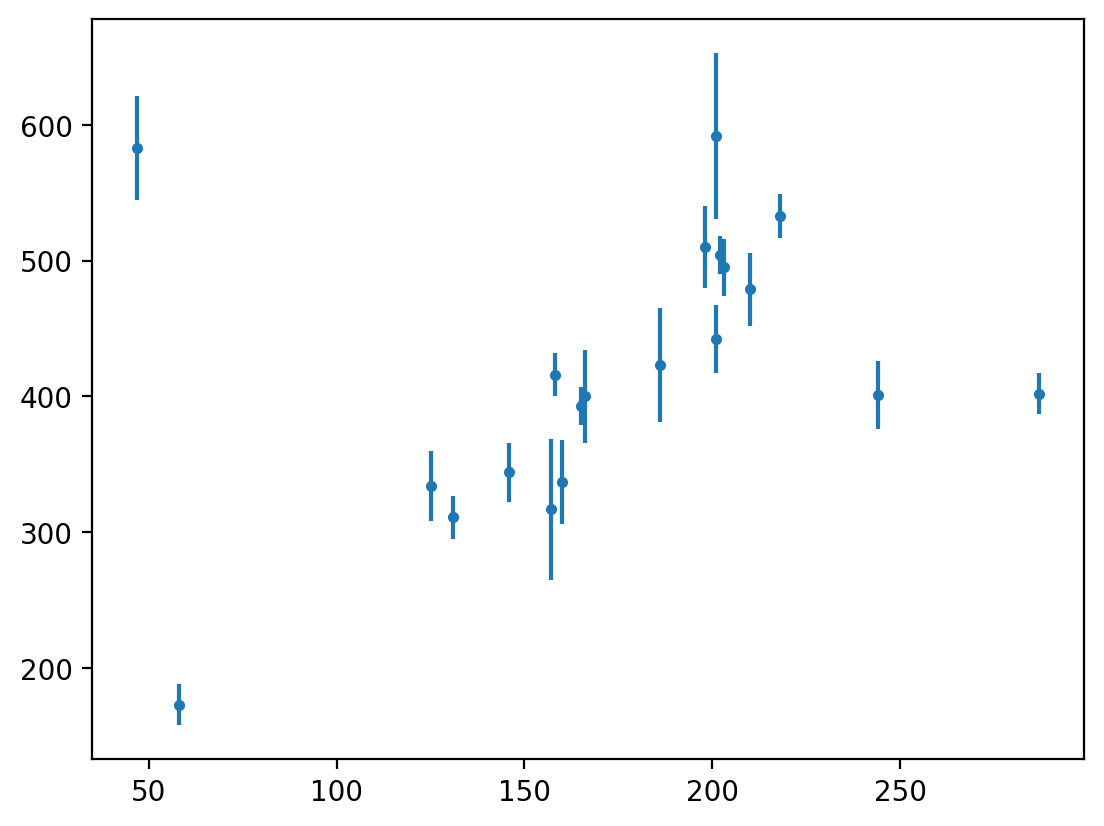

In [3]:
plt.errorbar(x, y, yerr=dy, fmt='.')

In [4]:
def squareLoss(a, b, x, y, dy):
    y_cal = (a*x) + b
    loss = np.sum(((y_cal - y.mean())**2)/(2*(dy**2)))
    
    return -loss

1.9500000000000006 118


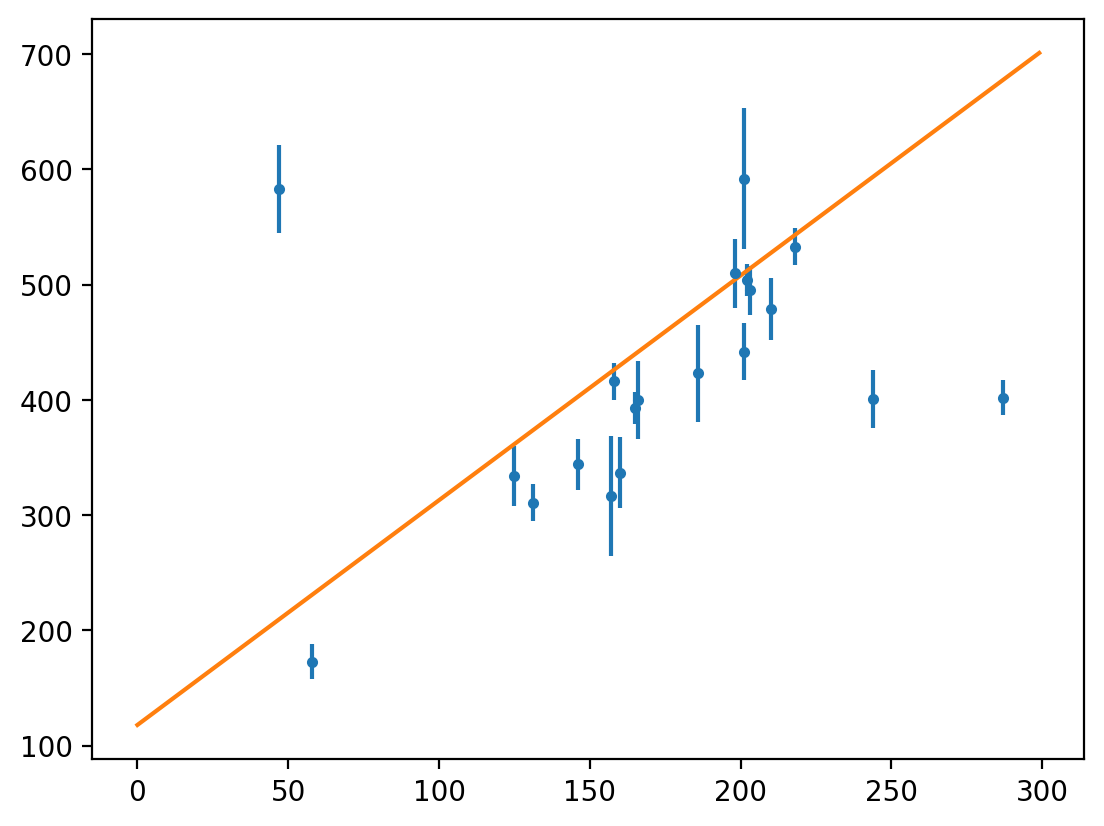

In [5]:
a_array = np.arange(1.25, 2.75, 0.1)
b_array = np.arange(100, 150, 1)
best_a, best_b = a_array[0], b_array[0]
loss = squareLoss(best_a, best_b, x, y, dy)
for a in a_array:
    for b in b_array:
        new_loss = squareLoss(a, b, x, y, dy)
        if (new_loss > loss):
            best_a, best_b, new_loss = a, b, loss

print(best_a, best_b)
plt.errorbar(x, y, yerr=dy, fmt='.')
x_line = np.arange(0, 300, 1)
plt.plot(x_line, best_a*x_line + best_b)

106.97891763684099
1.8500000000000005 119


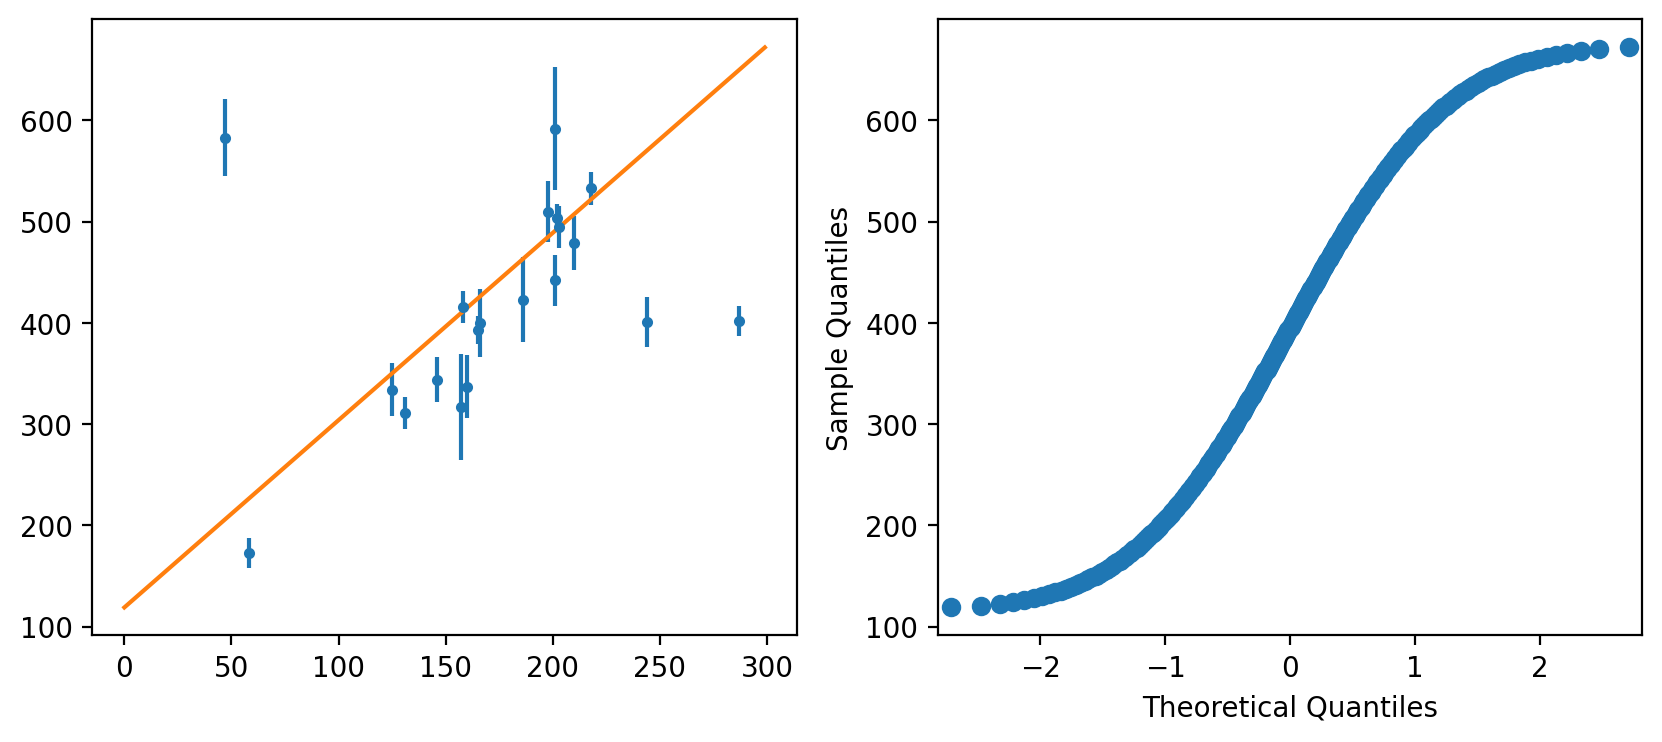

In [6]:
std = (best_a*x + best_b).std()
print(std)
new_y, new_x, new_dy = [], [], []
for i in range(len(y)):
    if np.abs(y[i] - (best_a*x[i] + best_b)) < 3*std:
        new_y.append(y[i])
        new_x.append(x[i])
        new_dy.append(dy[i])       
new_y, new_x, new_dy = np.array(new_y), np.array(new_x), np.array(new_dy)

best_a, best_b = a_array[0], b_array[0]
loss = squareLoss(best_a, best_b, new_x, new_y, new_dy)
for a in a_array:
    for b in b_array:
        new_loss = squareLoss(a, b, new_x, new_y, new_dy)
        if (new_loss > loss):
            best_a, best_b, new_loss = a, b, loss
print(best_a, best_b)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].errorbar(x, y, yerr=dy, fmt='.')
x_line = np.arange(0, 300, 1)
ax[0].plot(x_line, best_a*x_line + best_b)
sm.qqplot(best_a*x_line + best_b, ax=ax[1])
plt.show()

In [7]:
def huberLoss(param, x, y, dy):
    a, b = param
    y_cal = (a*x) + b
    loss = 0
    #Taking delta as 5
    for i in range(len(y)):
        u = np.abs((y_cal[i] - y[i])/dy[i])
        if (u < 5):
            loss += (u**2)/2
        else:
            loss += 5*(u - 2.5)
    return loss

Optimization terminated successfully.
         Current function value: 128.157106
         Iterations: 54
         Function evaluations: 104
1.439050021880909 155.8313388616568


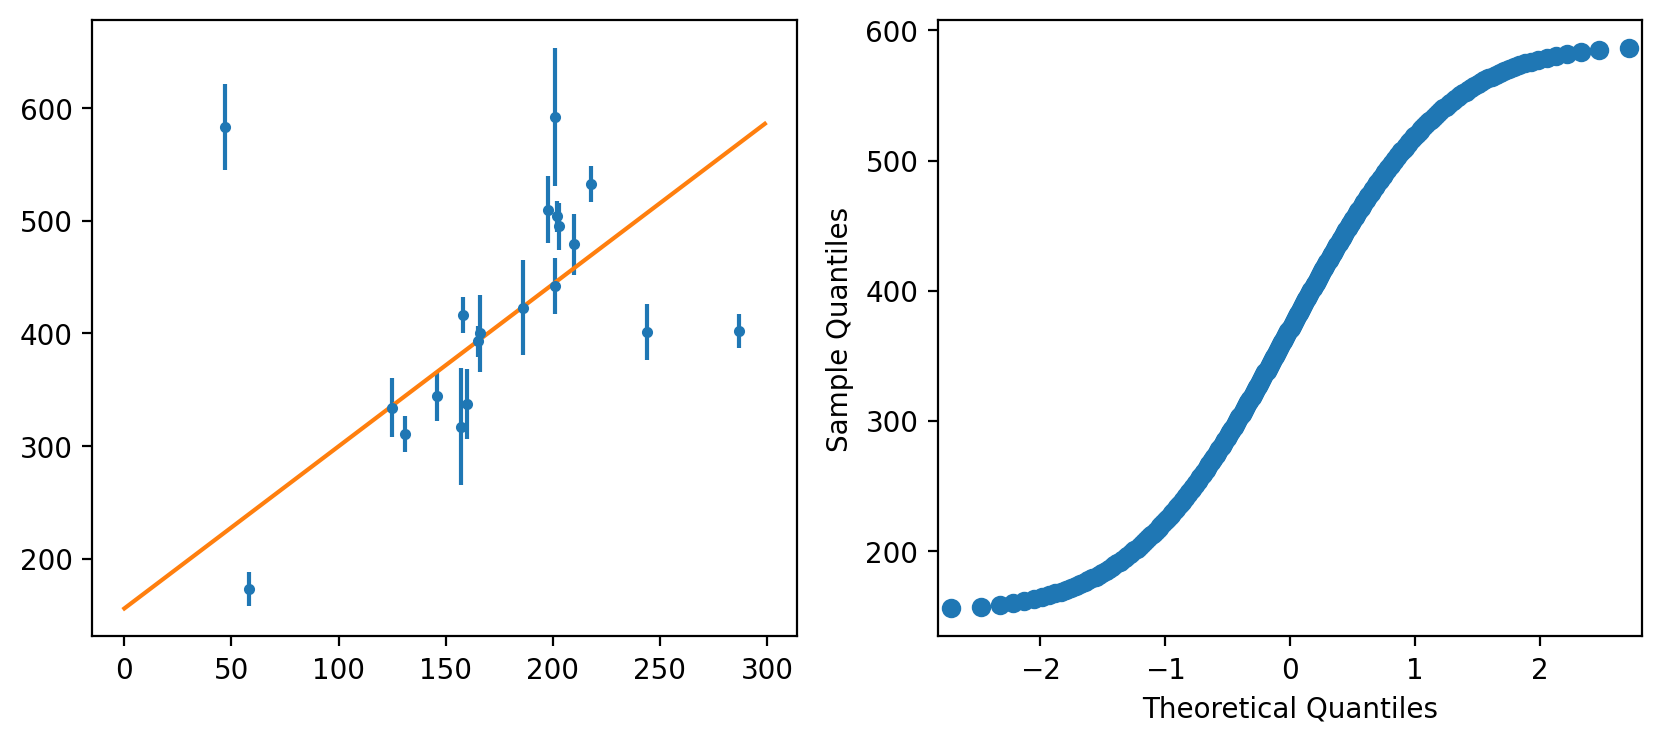

In [8]:
best_a2, best_b2 = scipy.optimize.fmin(huberLoss, (2, 100), args=(x, y, dy))
print(best_a2, best_b2)
fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax2[0].errorbar(x, y, yerr=dy, fmt='.')
x_line = np.arange(0, 300, 1)
ax2[0].plot(x_line, best_a2*x_line + best_b2)
sm.qqplot(best_a2*x_line + best_b2, ax=ax2[1])
plt.show()

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("Cepheids.csv")
df1 = df.loc[(df['Cloud'] == 'LMC') & (df['Mode'] == 'F')]
df2 = df.loc[(df['Cloud'] == 'LMC') & (df['Mode'] == '1')]
df3 = df.loc[(df['Cloud'] == 'SMC') & (df['Mode'] == 'F')]
df4 = df.loc[(df['Cloud'] == 'SMC') & (df['Mode'] == '1')]

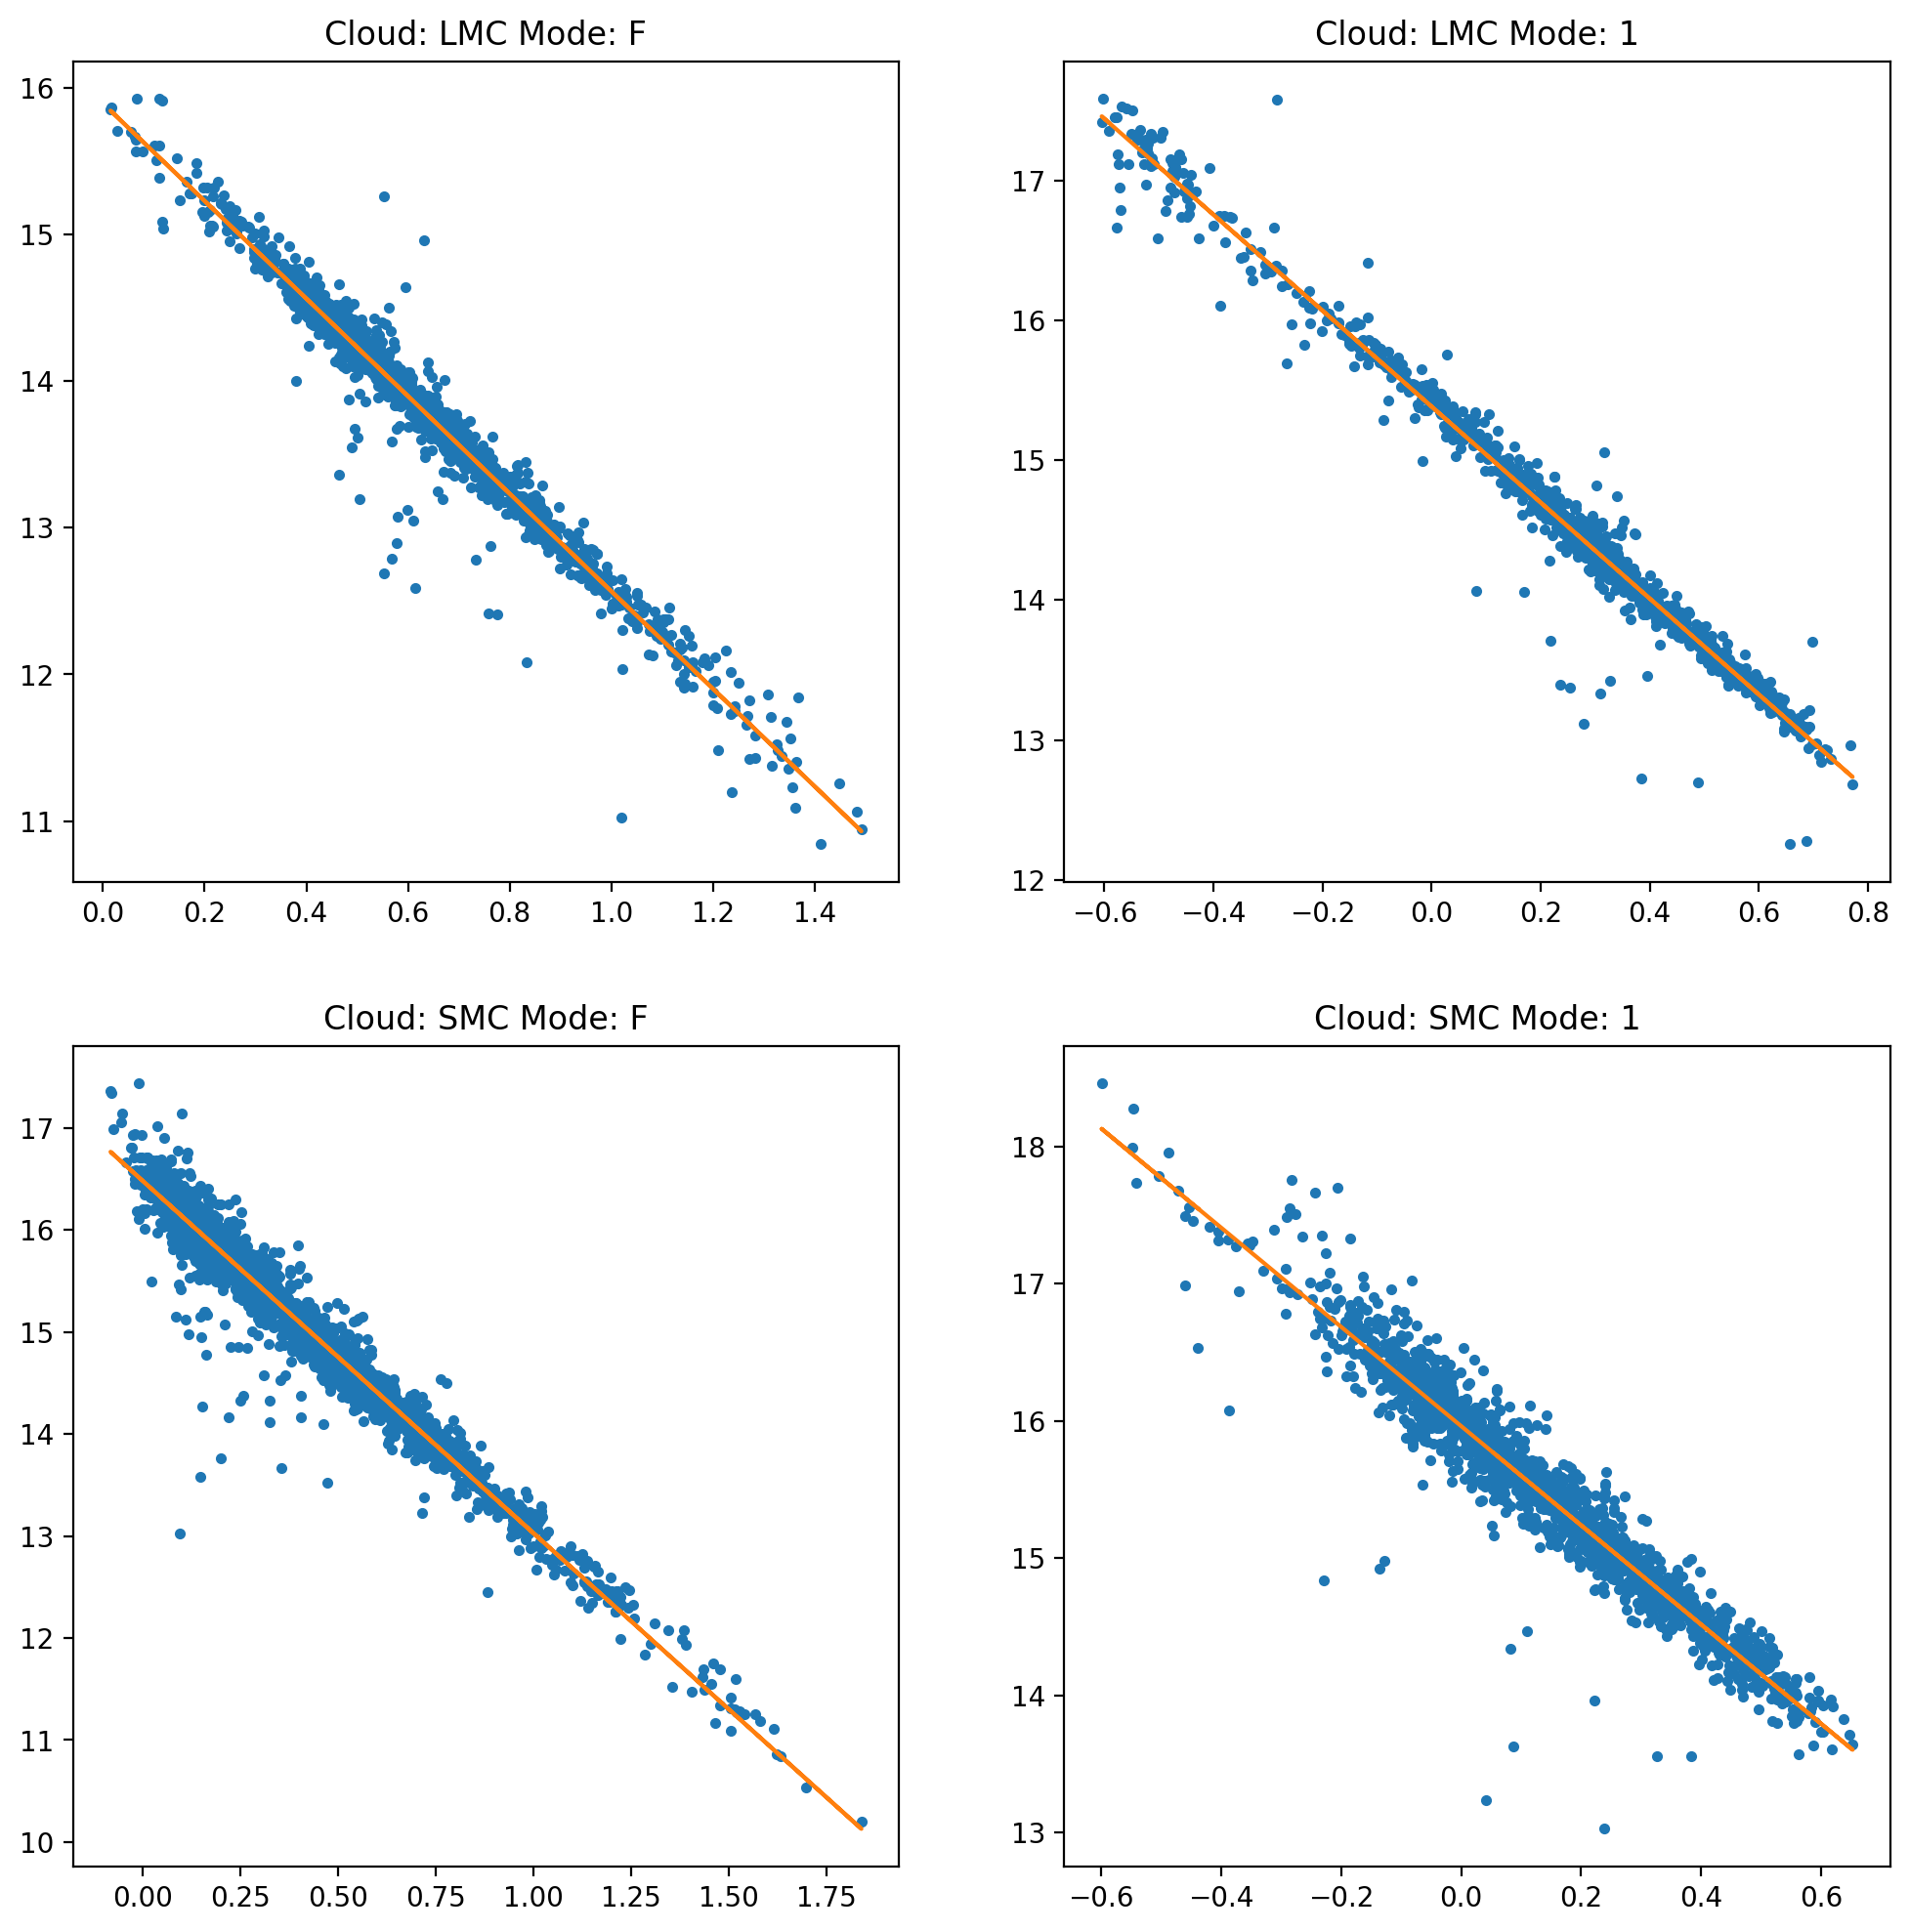

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].plot(df1['logP1'], df1['W'], '.')
best_a, best_b = scipy.optimize.fmin(huberLoss, (-2.5, 17),
                args=(np.array(df1['logP1']), np.array(df1['W']), np.ones(len(df1['W']))), disp=False)
ax[0, 0].plot(df1['logP1'], best_a*df1['logP1'] + best_b)
ax[0, 0].set_title("Cloud: LMC Mode: F")

ax[0, 1].plot(df2['logP1'], df2['W'], '.')
best_a2, best_b2 = scipy.optimize.fmin(huberLoss, (-2.5, 17),
                args=(np.array(df2['logP1']), np.array(df2['W']), np.ones(len(df2['W']))), disp=False)
ax[0, 1].plot(df2['logP1'], best_a2*df2['logP1'] + best_b2)
ax[0, 1].set_title("Cloud: LMC Mode: 1")

ax[1, 0].plot(df3['logP1'], df3['W'], '.')
best_a3, best_b3 = scipy.optimize.fmin(huberLoss, (-2.5, 17),
                args=(np.array(df3['logP1']), np.array(df3['W']), np.ones(len(df3['W']))), disp=False)
ax[1, 0].plot(df3['logP1'], best_a3*df3['logP1'] + best_b3)
ax[1, 0].set_title("Cloud: SMC Mode: F")

ax[1, 1].plot(df4['logP1'], df4['W'], '.')
best_a4, best_b4 = scipy.optimize.fmin(huberLoss, (-2.5, 17),
                args=(np.array(df4['logP1']), np.array(df4['W']), np.ones(len(df4['W']))), disp=False)
ax[1, 1].plot(df4['logP1'], best_a4*df4['logP1'] + best_b4)
ax[1, 1].set_title("Cloud: SMC Mode: 1")
plt.show()

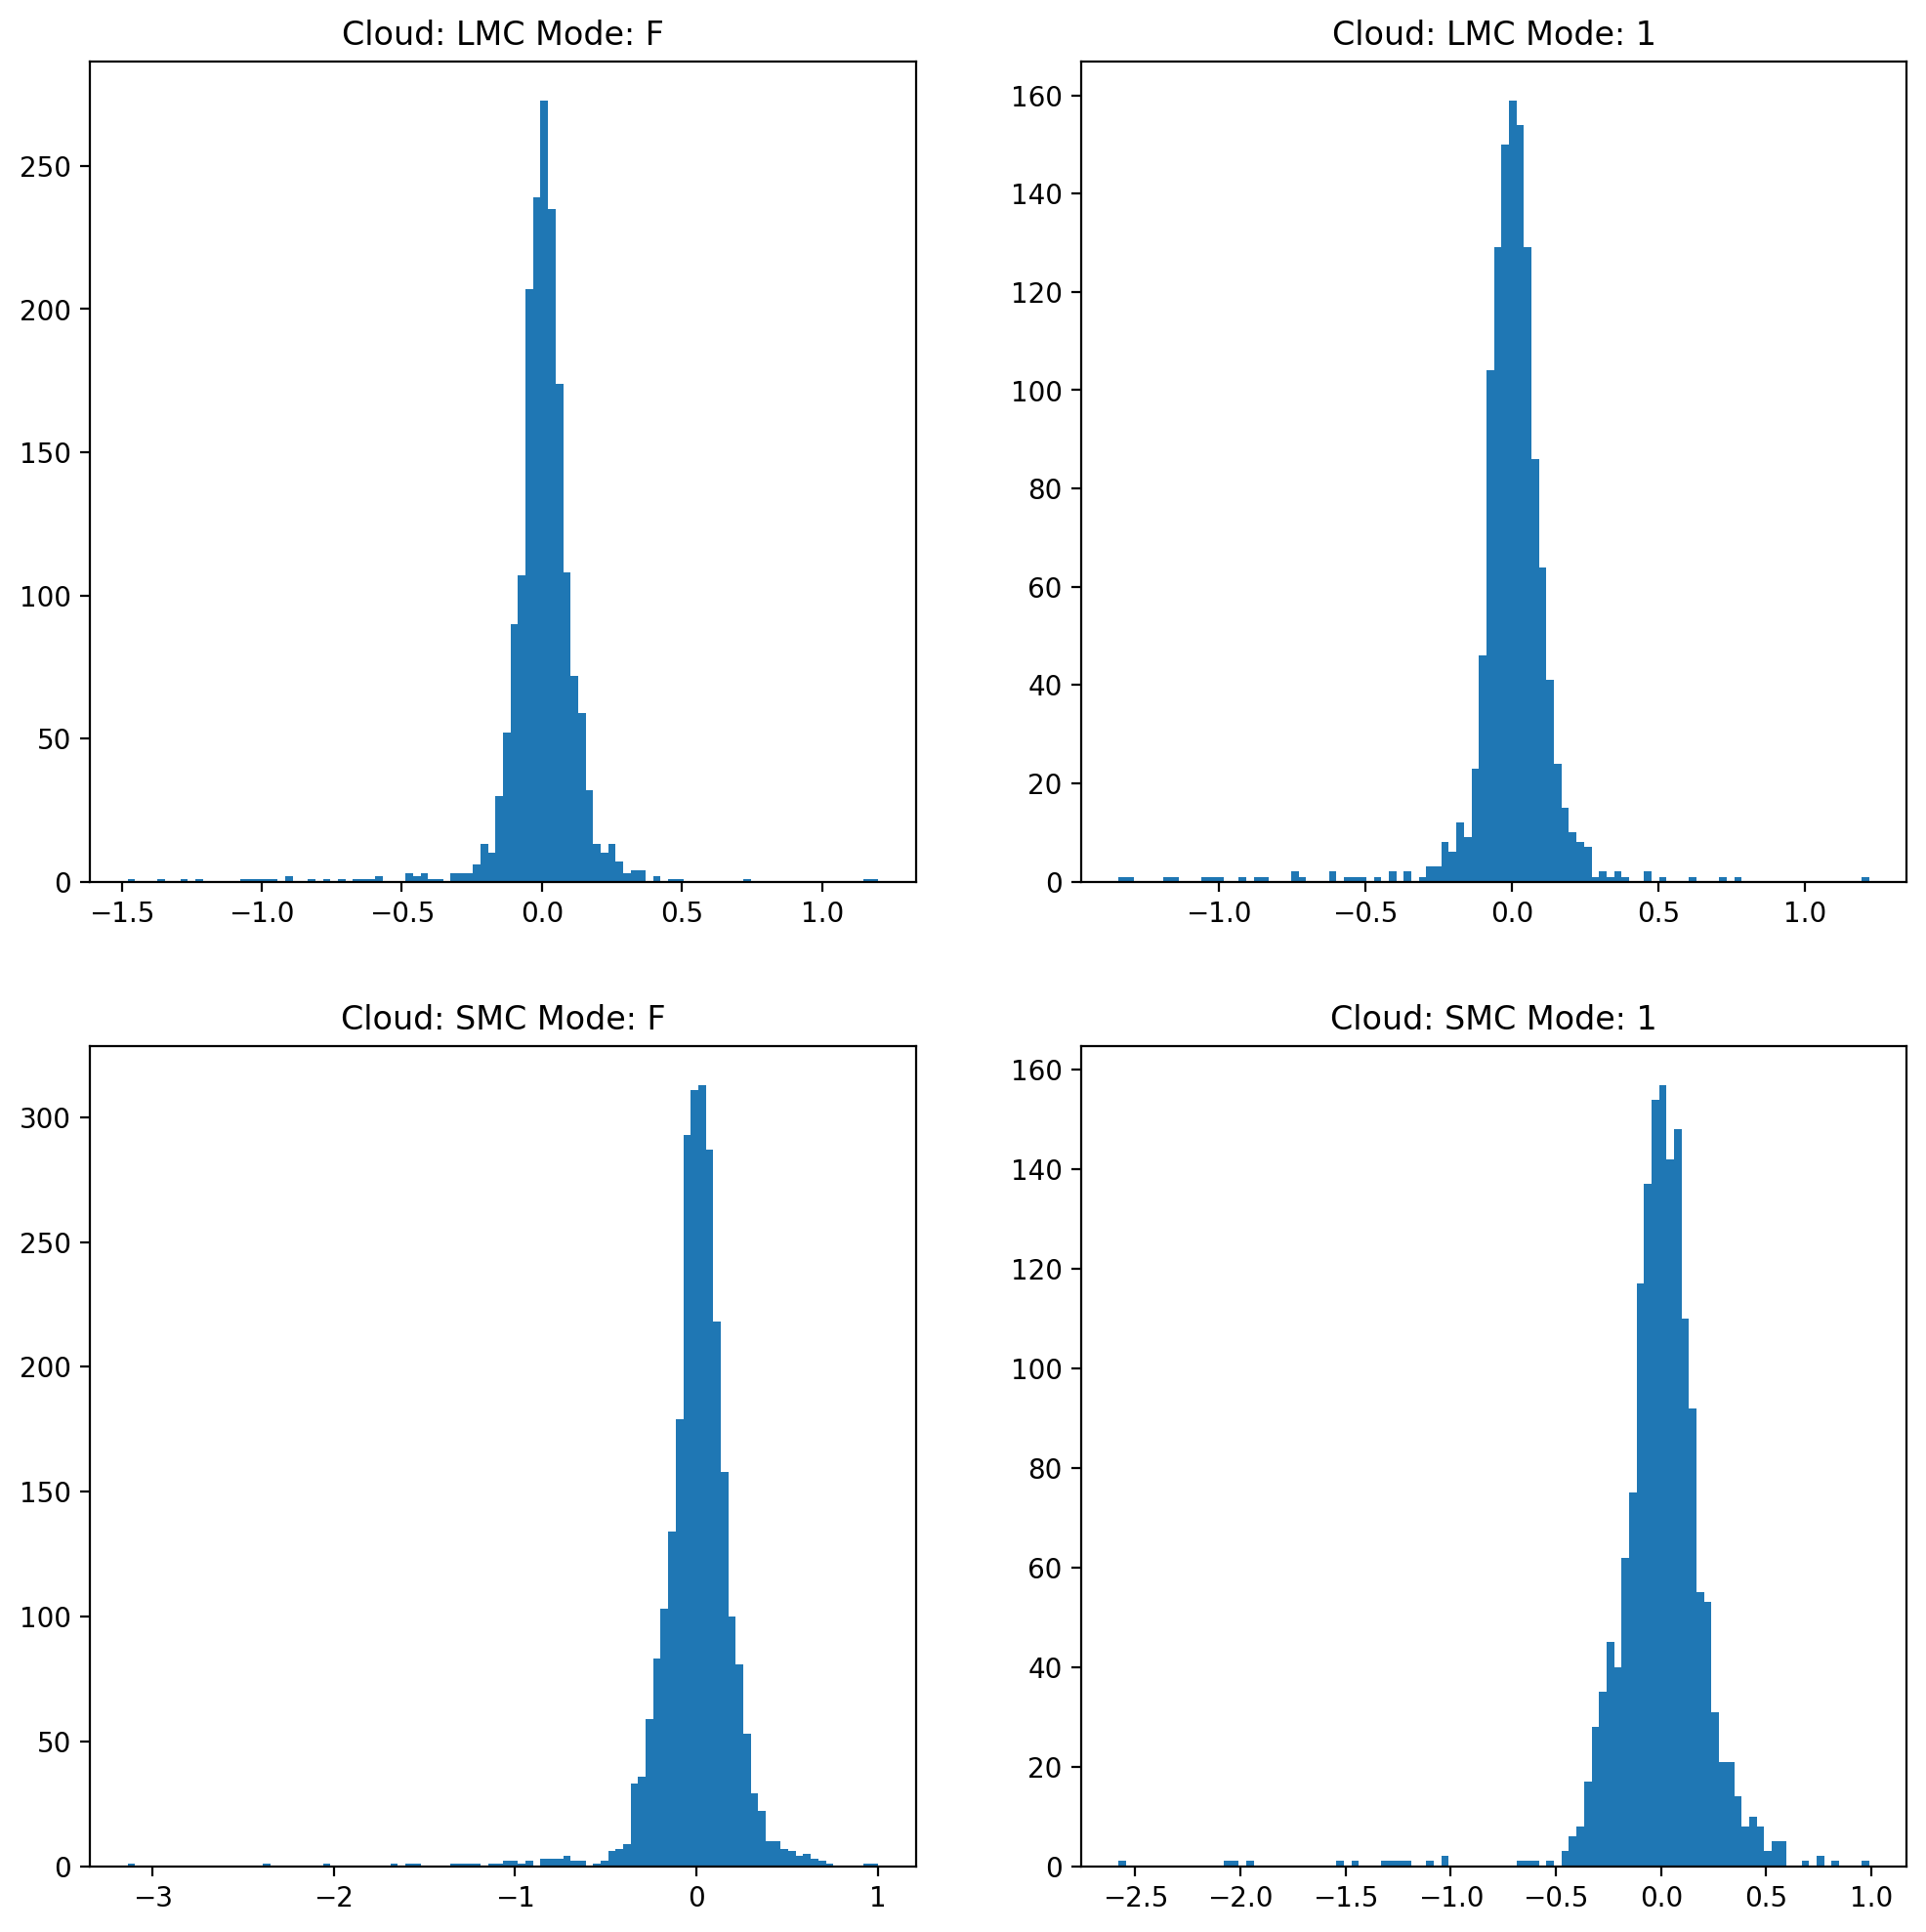

In [12]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

sigma1 = (df1['W'] - (best_a*df1['logP1'] + best_b))
ax2[0, 0].hist(sigma1, bins=100)
ax2[0, 0].set_title("Cloud: LMC Mode: F")

sigma2 = (df2['W'] - (best_a2*df2['logP1'] + best_b2))
ax2[0, 1].hist(sigma2, bins=100)
ax2[0, 1].set_title("Cloud: LMC Mode: 1")

sigma3 = (df3['W'] - (best_a3*df3['logP1'] + best_b3))
ax2[1, 0].hist(sigma3, bins=100)
ax2[1, 0].set_title("Cloud: SMC Mode: F")

sigma4 = (df4['W'] - (best_a4*df4['logP1'] + best_b4))
ax2[1, 1].hist(sigma4, bins=100)
ax2[1, 1].set_title("Cloud: SMC Mode: 1")

plt.show()

The residuals appear to draw from a normal distribution

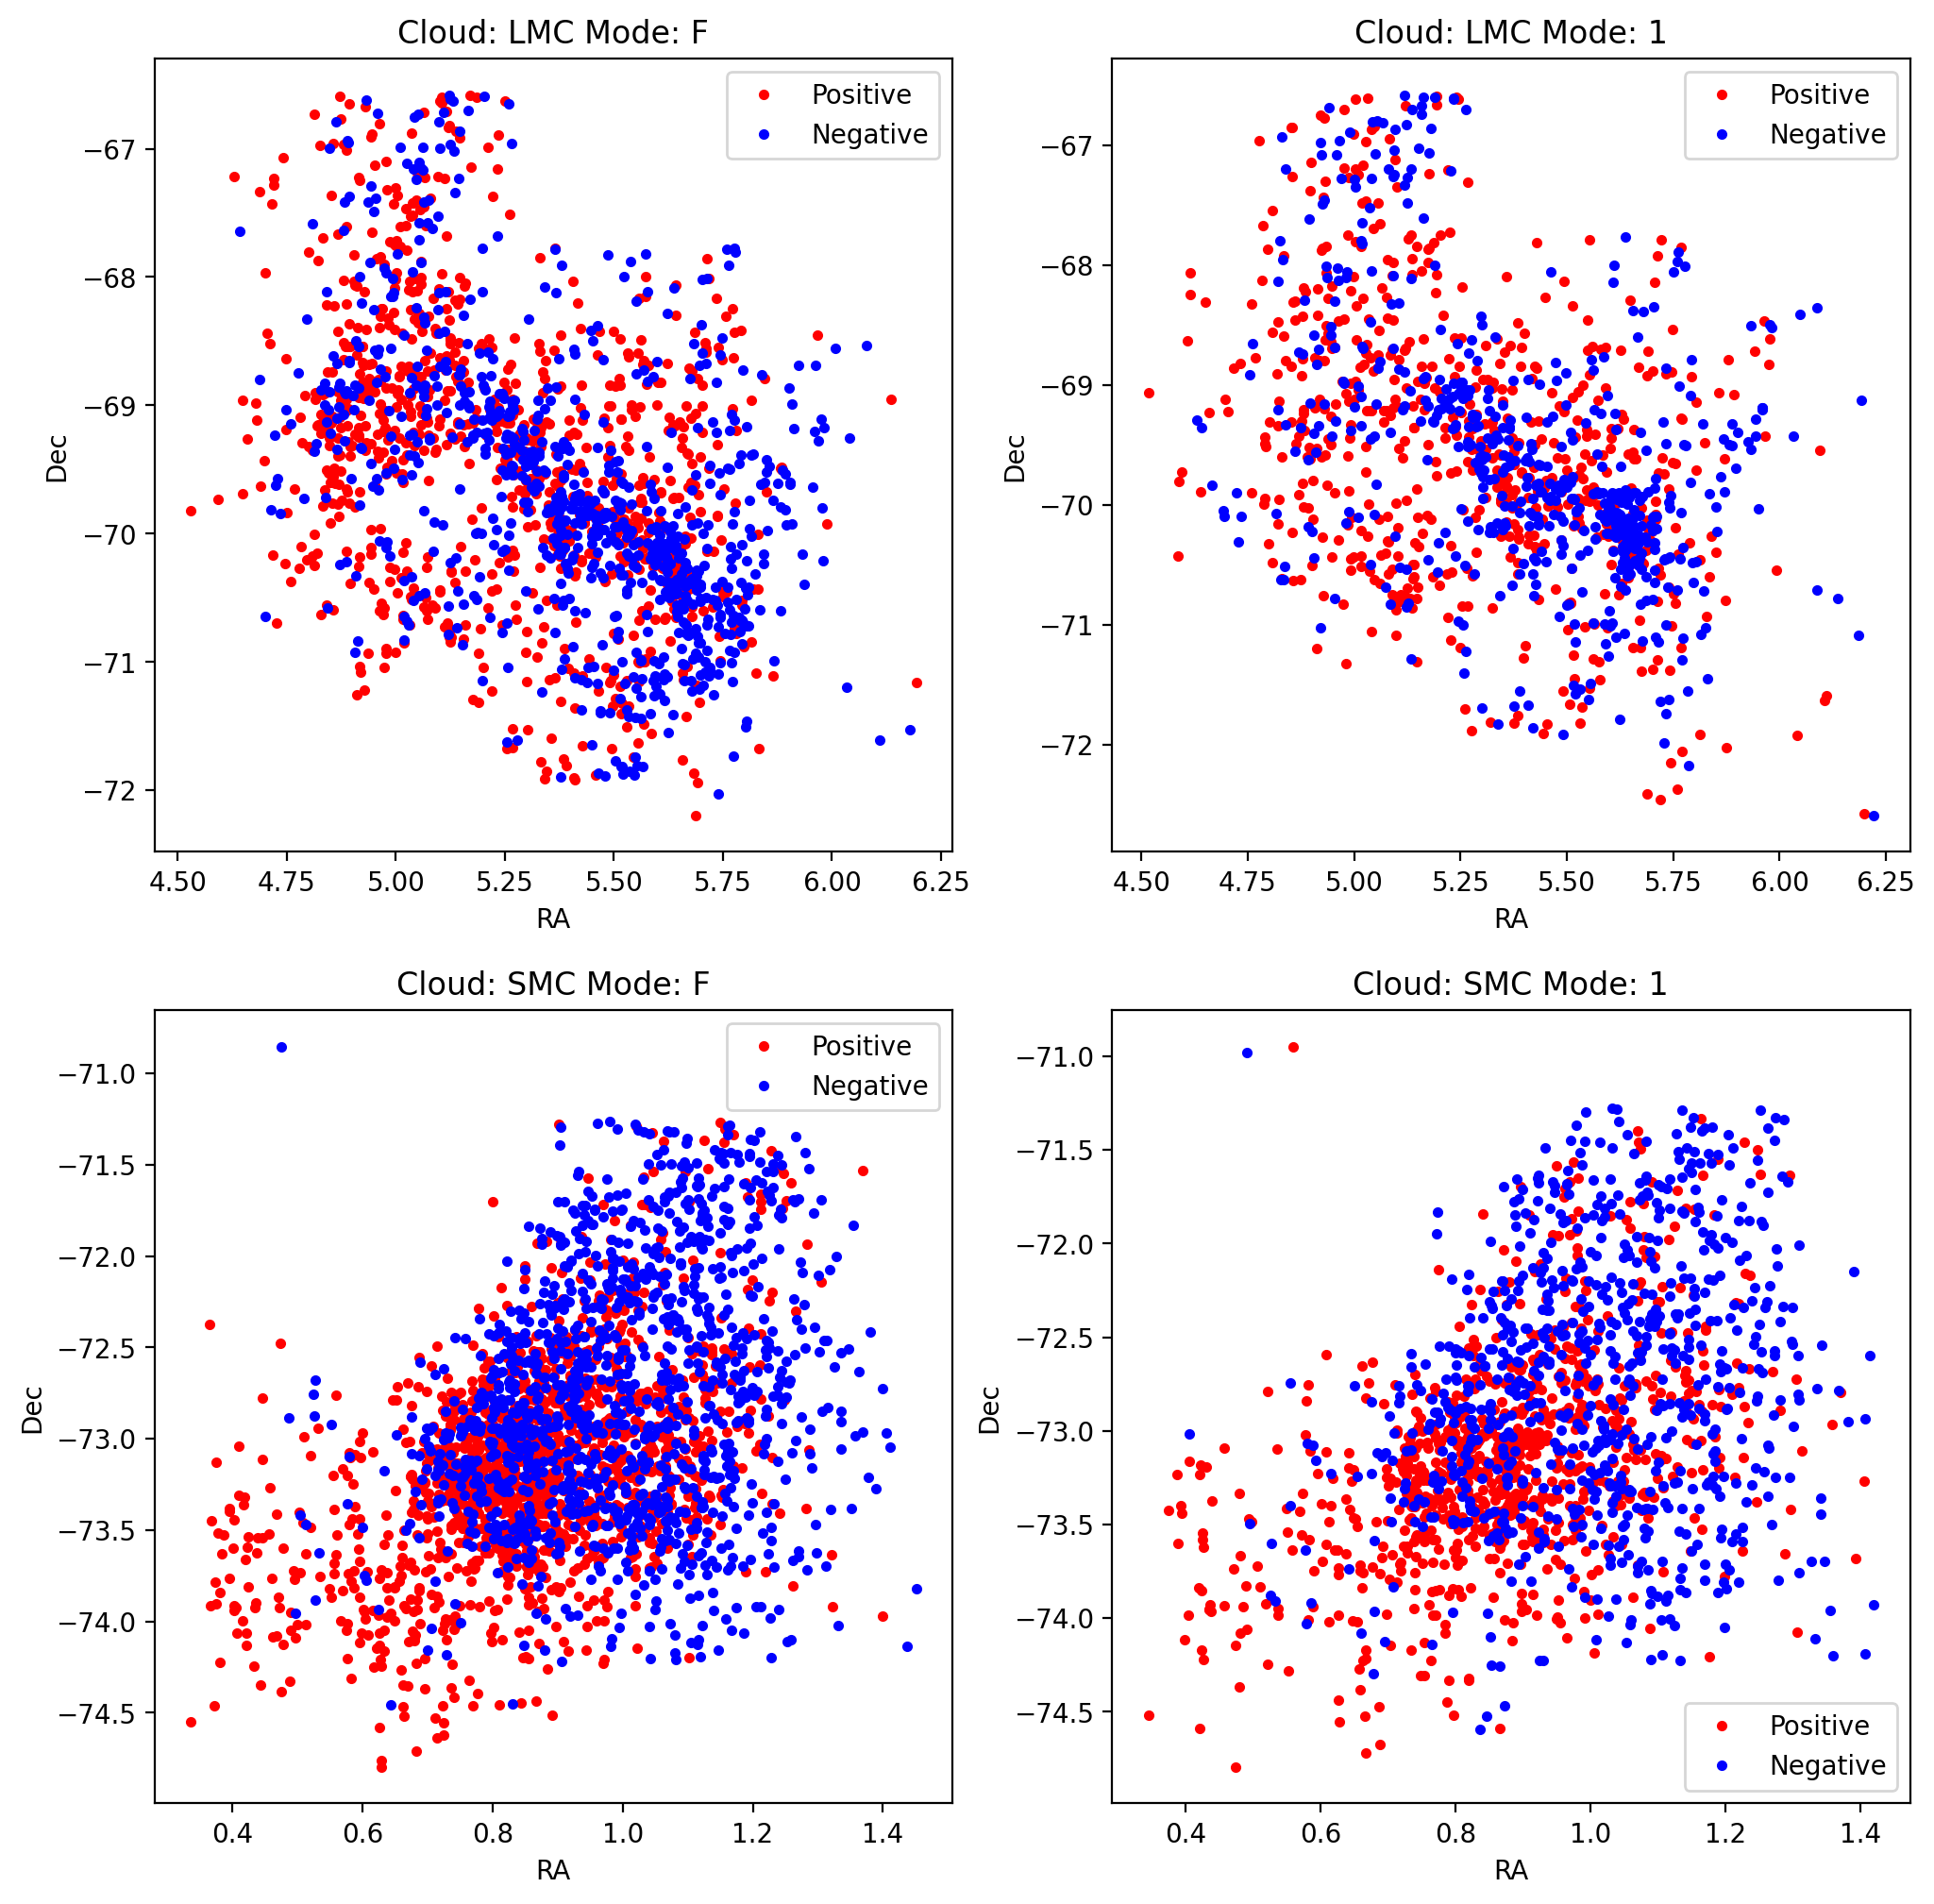

In [13]:
fig3, ax3 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

mask1Pos = sigma1 > 0
mask1Neg = sigma1 < 0
ax3[0, 0].plot(df1['RA0'][mask1Pos], df1['Decl0'][mask1Pos], '.', color="red", label="Positive")
ax3[0, 0].plot(df1['RA0'][mask1Neg], df1['Decl0'][mask1Neg], '.', color="blue", label="Negative")
ax3[0, 0].set_xlabel("RA")
ax3[0, 0].set_ylabel("Dec")
ax3[0, 0].set_title("Cloud: LMC Mode: F")
ax3[0, 0].legend()

mask2Pos = sigma2 > 0
mask2Neg = sigma2 < 0
ax3[0, 1].plot(df2['RA0'][mask2Pos], df2['Decl0'][mask2Pos], '.', color="red", label="Positive")
ax3[0, 1].plot(df2['RA0'][mask2Neg], df2['Decl0'][mask2Neg], '.', color="blue", label="Negative")
ax3[0, 1].set_xlabel("RA")
ax3[0, 1].set_ylabel("Dec")
ax3[0, 1].set_title("Cloud: LMC Mode: 1")
ax3[0, 1].legend()

mask3Pos = sigma3 > 0
mask3Neg = sigma3 < 0
ax3[1, 0].plot(df3['RA0'][mask3Pos], df3['Decl0'][mask3Pos], '.', color="red", label="Positive")
ax3[1, 0].plot(df3['RA0'][mask3Neg], df3['Decl0'][mask3Neg], '.', color="blue", label="Negative")
ax3[1, 0].set_xlabel("RA")
ax3[1, 0].set_ylabel("Dec")
ax3[1, 0].set_title("Cloud: SMC Mode: F")
ax3[1, 0].legend()

mask4Pos = sigma4 > 0
mask4Neg = sigma4 < 0
ax3[1, 1].plot(df4['RA0'][mask4Pos], df4['Decl0'][mask4Pos], '.', color="red", label="Positive")
ax3[1, 1].plot(df4['RA0'][mask4Neg], df4['Decl0'][mask4Neg], '.', color="blue", label="Negative")
ax3[1, 1].set_xlabel("RA")
ax3[1, 1].set_ylabel("Dec")
ax3[1, 1].set_title("Cloud: SMC Mode: 1")
ax3[1, 1].legend()

plt.show()

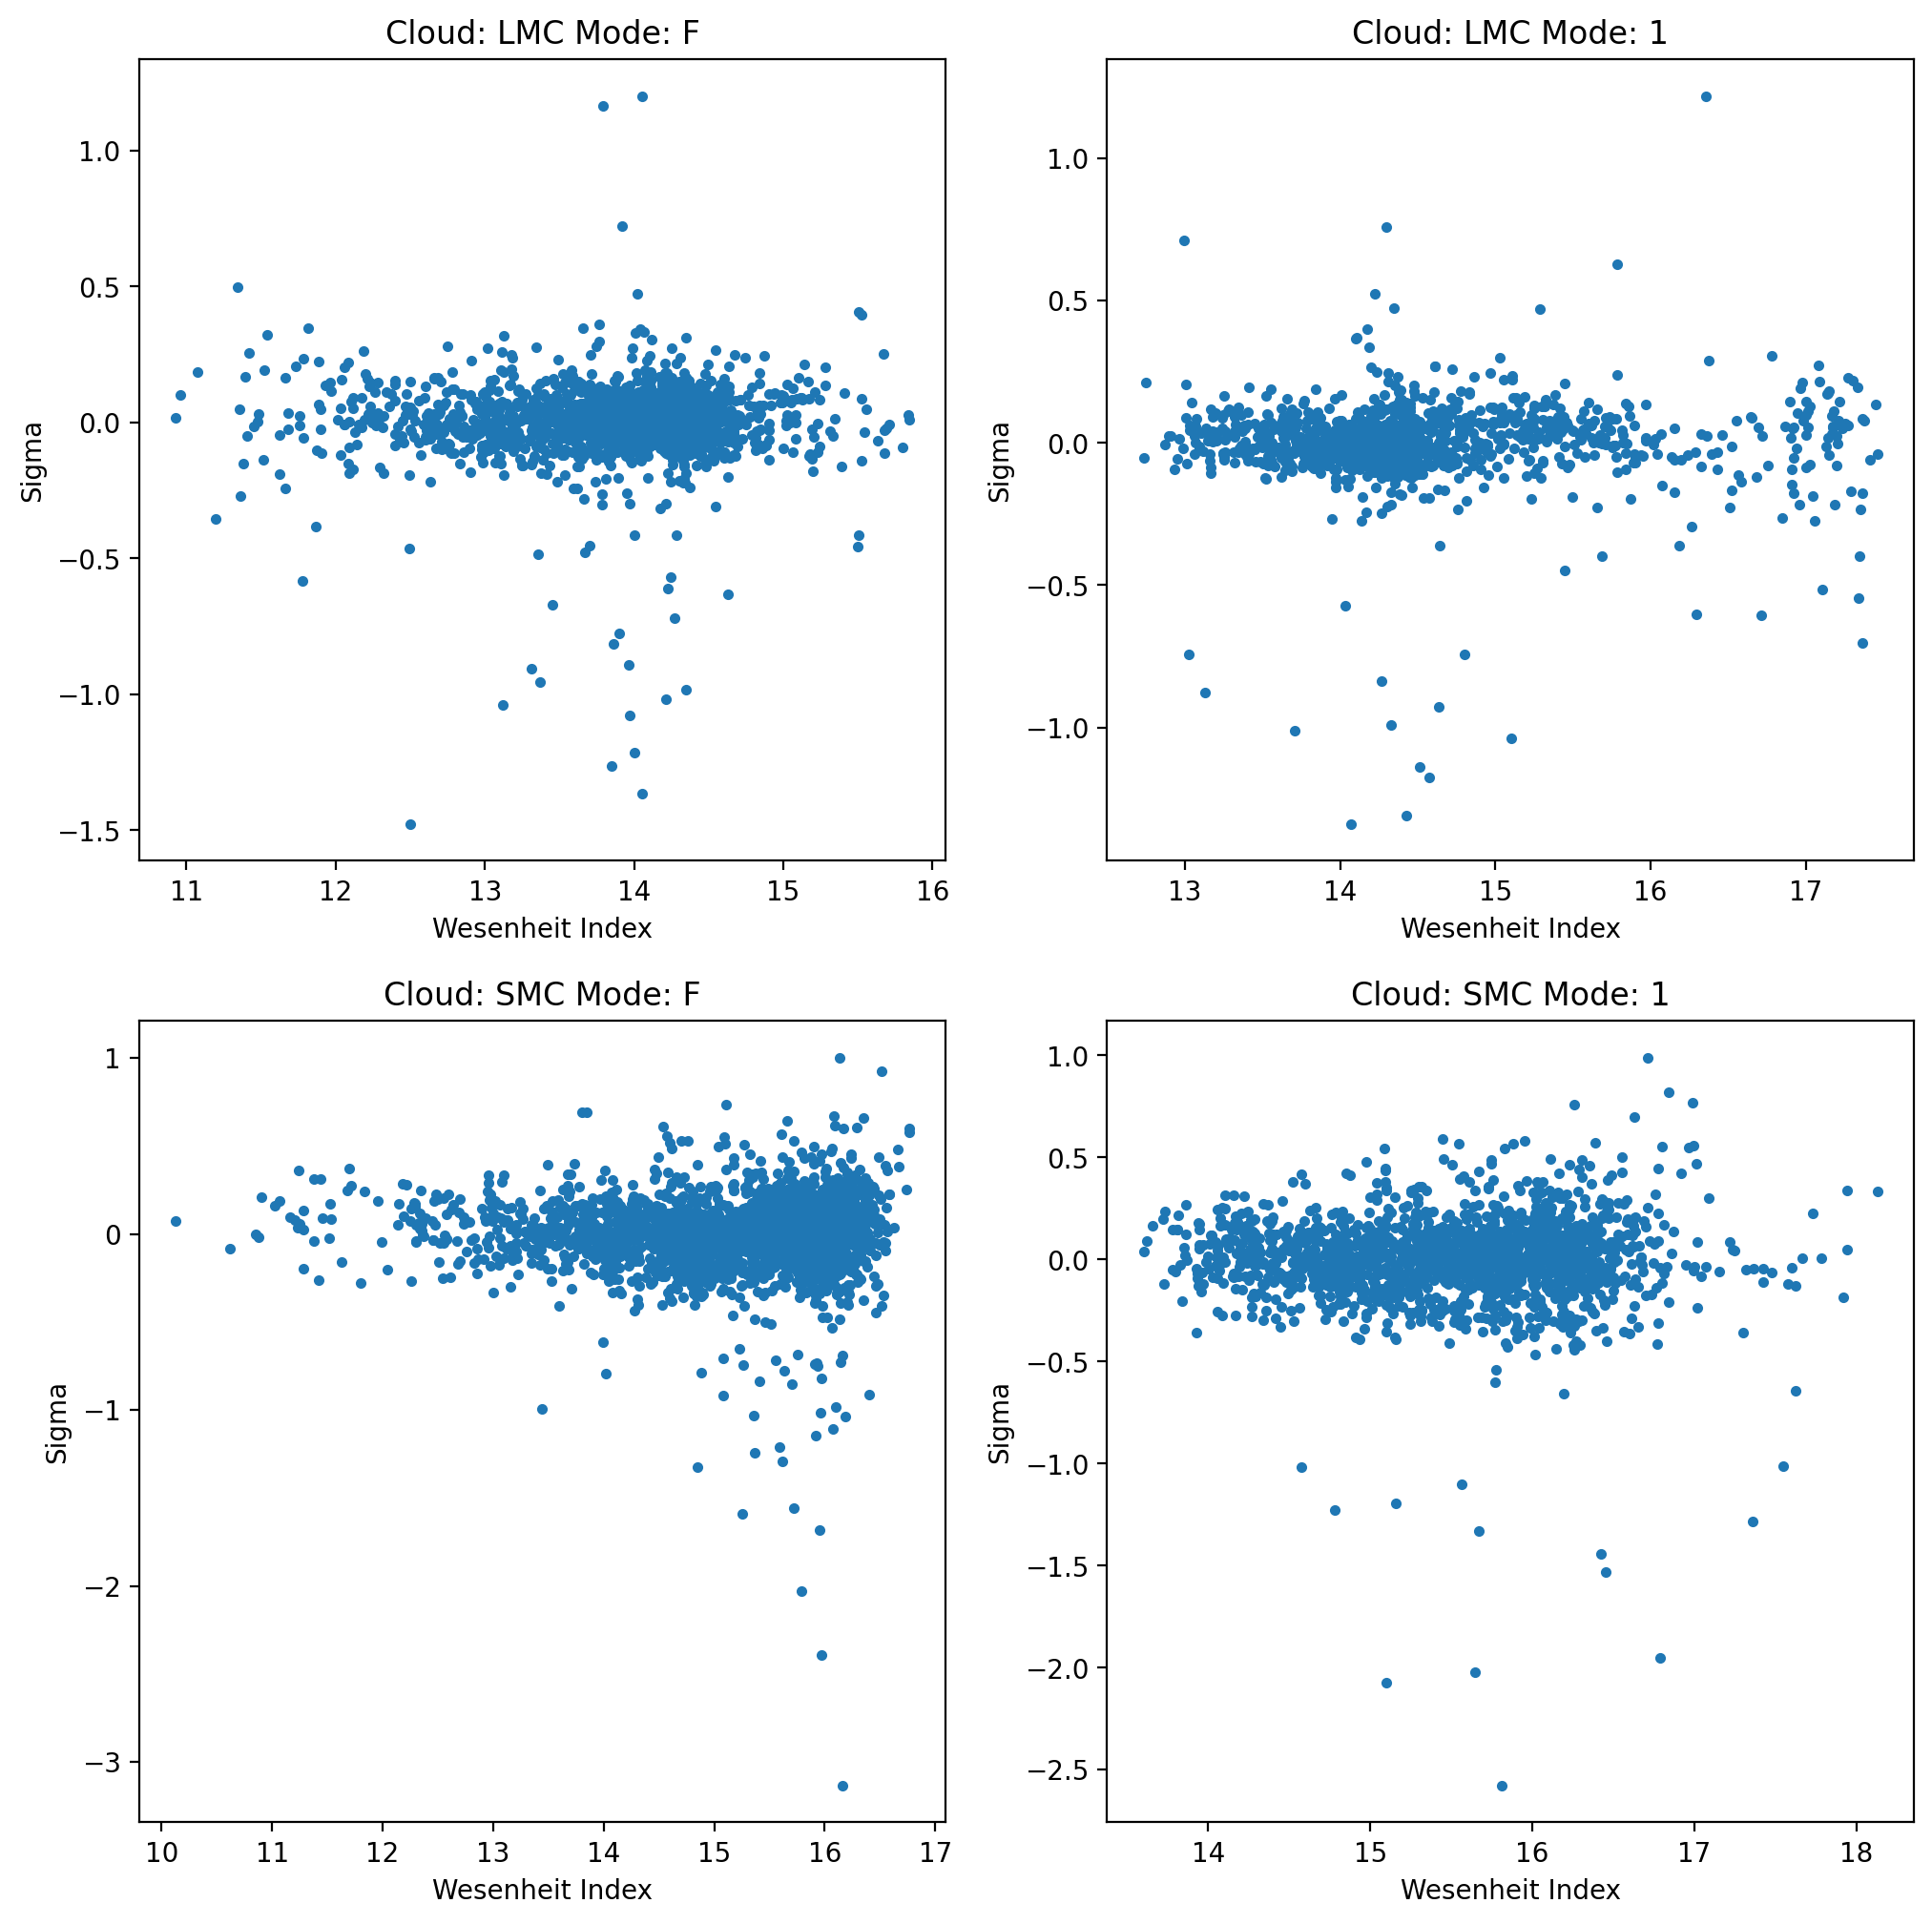

In [14]:
fig4, ax4 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax4[0, 0].plot(best_a*df1['logP1'] + best_b, sigma1, '.')
ax4[0, 0].set_ylabel("Sigma")
ax4[0, 0].set_xlabel("Wesenheit Index")
ax4[0, 0].set_title("Cloud: LMC Mode: F")

ax4[0, 1].plot(best_a2*df2['logP1'] + best_b2, sigma2, '.')
ax4[0, 1].set_ylabel("Sigma")
ax4[0, 1].set_xlabel("Wesenheit Index")
ax4[0, 1].set_title("Cloud: LMC Mode: 1")

ax4[1, 0].plot(best_a3*df3['logP1'] + best_b3, sigma3, '.')
ax4[1, 0].set_ylabel("Sigma")
ax4[1, 0].set_xlabel("Wesenheit Index")
ax4[1, 0].set_title("Cloud: SMC Mode: F")

ax4[1, 1].plot(best_a4*df4['logP1'] + best_b4, sigma4, '.')
ax4[1, 1].set_ylabel("Sigma")
ax4[1, 1].set_xlabel("Wesenheit Index")
ax4[1, 1].set_title("Cloud: SMC Mode: 1")
plt.show()

The deviations from the measured data are equally likely to be positive or negative across the Weisenheit index. This makes sense as the Index is supposed to be independent of extinction.

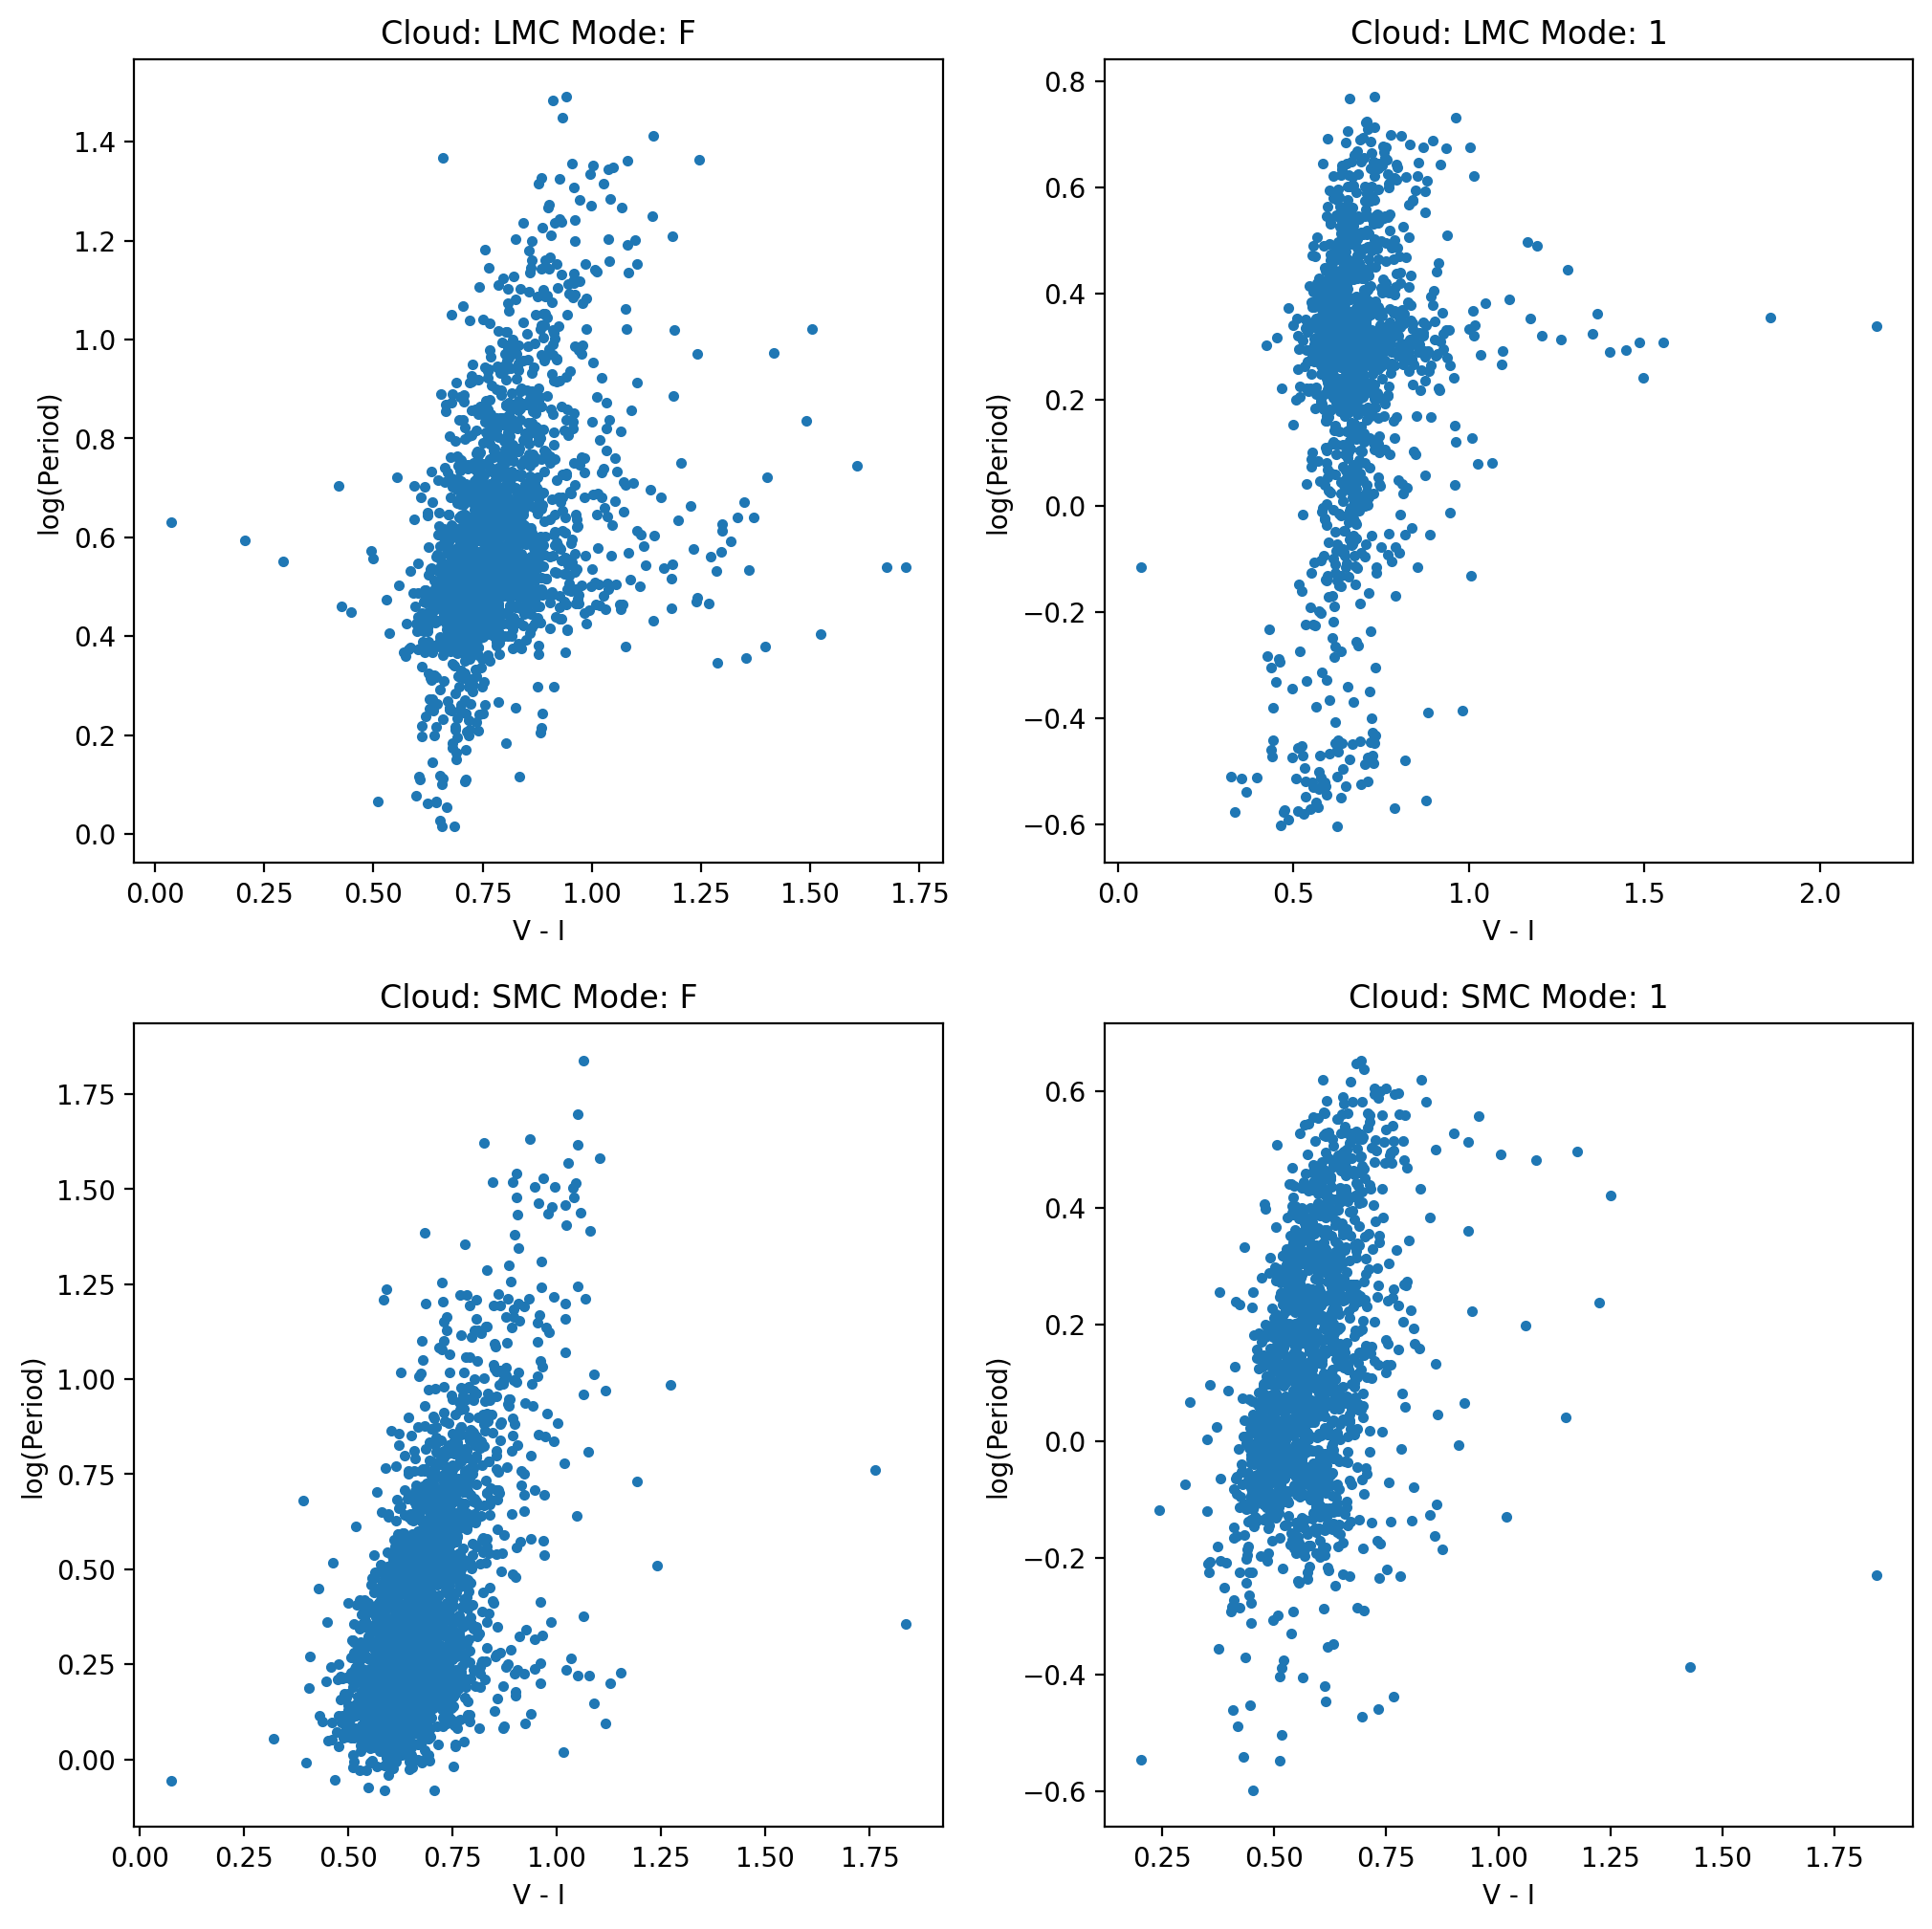

In [15]:
fig5, ax5 = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax5[0, 0].plot(df1['VI'], df1['logP1'], '.')
ax5[0, 0].set_xlabel("V - I")
ax5[0, 0].set_ylabel("log(Period)")
ax5[0, 0].set_title("Cloud: LMC Mode: F")

ax5[0, 1].plot(df2['VI'], df2['logP1'], '.')
ax5[0, 1].set_xlabel("V - I")
ax5[0, 1].set_ylabel("log(Period)")
ax5[0, 1].set_title("Cloud: LMC Mode: 1")

ax5[1, 0].plot(df3['VI'], df3['logP1'], '.')
ax5[1, 0].set_xlabel("V - I")
ax5[1, 0].set_ylabel("log(Period)")
ax5[1, 0].set_title("Cloud: SMC Mode: F")

ax5[1, 1].plot(df4['VI'], df4['logP1'], '.')
ax5[1, 1].set_xlabel("V - I")
ax5[1, 1].set_ylabel("log(Period)")
ax5[1, 1].set_title("Cloud: SMC Mode: 1")
plt.show()